## Generator and Grayscale images
Each image 106x79x1

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8782240353145895990]

In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
width, height = 106, 79
train_data_dir = '../dices/gen_x3_3/train'
test_data_dir = '../dices/gen_x3_3/test'
nb_train_samples = 47232
nb_test_samples = 11808
epochs = 20
batch_size = 512

input_shape = (width, height, 1)

In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(9, 6), strides=(2, 2), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(7, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(5, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [6]:
# summarize model and apply checkpoints
print(model.summary())
filepath = 'simple_106x79/simple_NN_106x79-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 37, 32)        1760      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 14, 64)        71744     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 4, 256)         327936    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.20,
    zoom_range=0.15,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    classes=['1', '2', '3', '4', '5', '6'],
    shuffle=True,
    seed=2018)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width, height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    classes=['1', '2', '3', '4', '5', '6'],
    shuffle=True,
    seed=2018)

Found 47232 images belonging to 6 classes.
Found 11808 images belonging to 6 classes.


In [9]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list,
    shuffle=True,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size)

Epoch 1/20
92/92 [==============================] - 52s 565ms/step - loss: 1.7578 - acc: 0.1976 - val_loss: 1.6955 - val_acc: 0.2445
Epoch 2/20
92/92 [==============================] - 51s 555ms/step - loss: 1.6080 - acc: 0.2820 - val_loss: 1.5052 - val_acc: 0.3246
Epoch 3/20
92/92 [==============================] - 51s 558ms/step - loss: 1.4669 - acc: 0.3443 - val_loss: 1.4317 - val_acc: 0.3638
Epoch 4/20
92/92 [==============================] - 51s 557ms/step - loss: 1.3922 - acc: 0.3813 - val_loss: 1.3151 - val_acc: 0.4034
Epoch 5/20
92/92 [==============================] - 51s 551ms/step - loss: 1.3434 - acc: 0.4017 - val_loss: 1.2868 - val_acc: 0.4356
Epoch 6/20
92/92 [==============================] - 50s 549ms/step - loss: 1.2869 - acc: 0.4358 - val_loss: 1.2166 - val_acc: 0.4614
Epoch 7/20
92/92 [==============================] - 50s 545ms/step - loss: 1.2481 - acc: 0.4512 - val_loss: 1.2038 - val_acc: 0.4715
Epoch 8/20
92/92 [==============================] - 51s 549ms/step - 

In [10]:
score = model.evaluate_generator(test_generator)
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

Accuracy: 68.03%
Test loss: 0.7506392745144645
Test accuracy 0.6803014905149052


In [11]:
model_json = model.to_json()
with open('simple_NN_106x79_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('simple_NN_106x79_weights.h5')
print('Saved model weights')

Saved model weights


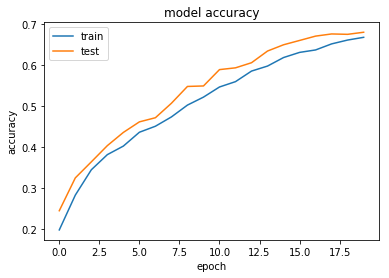

In [12]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

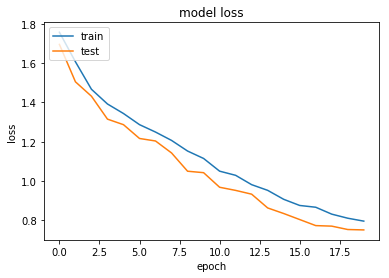

In [13]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
plot_model(model, to_file='simple_106x79/simple_NN_106x79_plot.png', show_shapes=True, show_layer_names=True)

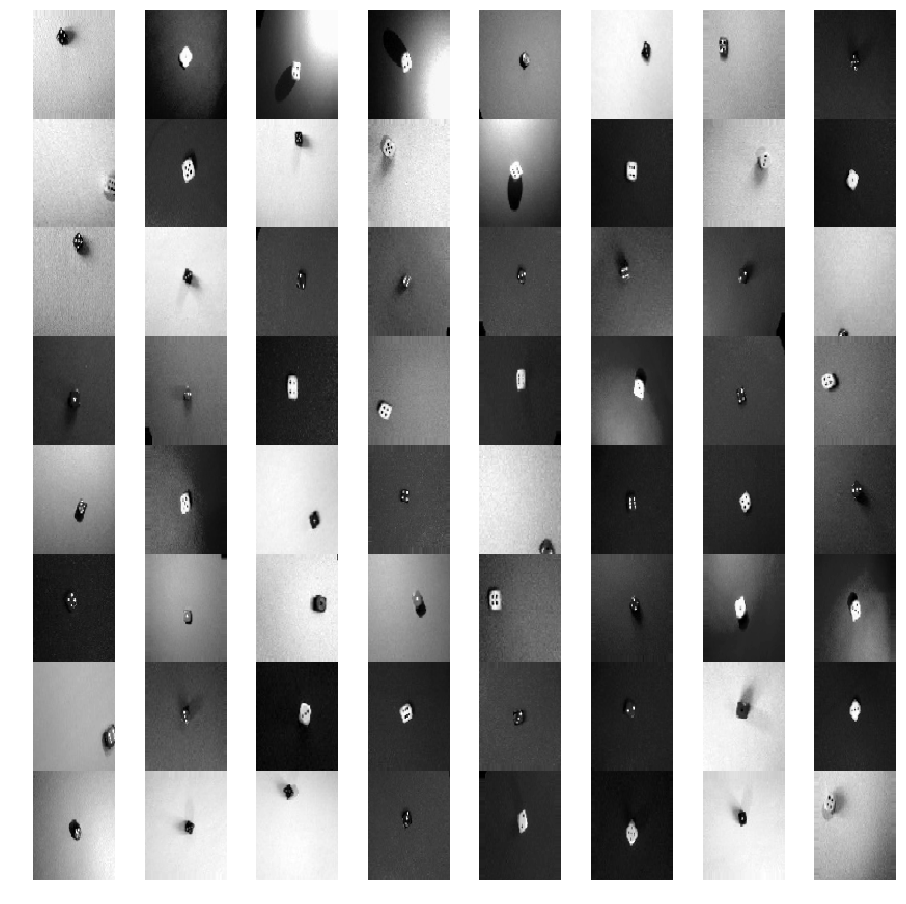

In [15]:
x_batch, y_batch = next(train_generator)
fig = plt.figure(figsize=(16,16))
for i in range(0, 64):
    plt.subplot(8,8,1+i)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.gray()
    image = x_batch[i]
    image = image.squeeze()
    plt.imshow(image)
plt.show()
    
# fig = plt.figure(figsize=(16,16))
# for i in range(0,64):
#     plt.subplot(8,8,1+i)
#     plt.axis('off')
#     plt.subplots_adjust(wspace=0, hspace=0)
#     random_image = random.randint(0, 100800)
#     img=immatrix[random_image].reshape(rows, cols)
#     plt.imshow(img)
# plt.show()